In [17]:
import cmsisdsp as dsp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io import loadmat
from dataclasses import dataclass

In [25]:
# numpy automatically upgrades to f64 if f64 is present in computation
# so we have to manually force f32 usage throughout
# Force everything to float32 for embedded compatibility
DTYPE = np.float32

@dataclass
class IMUData:
    """IMU measurements in float32"""
    gyro: np.ndarray  # rad/s [3x1]
    accel: np.ndarray  # m/s^2 [3x1]

    def __post_init__(self):
        self.gyro = self.gyro.astype(DTYPE)
        self.accel = self.accel.astype(DTYPE)

def quat_mult(q1, q2):
    """Quaternion multiplication"""
    # Ensure DTYPE inputs
    q1 = q1.astype(DTYPE)
    q2 = q2.astype(DTYPE)
    return dsp.arm_quaternion_product_single_f32(q1, q2)

def quat_conj(q):
    """Quaternion conjugate"""
    q = q.astype(DTYPE)
    return dsp.arm_quaternion_conjugate_f32(q)

def quaternion_to_dcm(q):
    """
    Convert quaternion to DCM (Body-to-Inertial/NED) - matches MATLAB CB2I
    Uses alternative formulation: CB2I = (s^2 - dot(v,v))*I + 2*(v*v') + 2*s*skew(v)
    CMSIS-DSP operations used where possible
    """
    q = q.astype(DTYPE)
    
    # Normalize quaternion using CMSIS-DSP
    q = dsp.arm_quaternion_normalize_f32(q)
    
    # Extract scalar and vector parts
    s = q[0]
    v = q[1:4]
    
    # Compute dot(v, v) using CMSIS-DSP
    v_dot_v = dsp.arm_dot_prod_f32(v, v)
    
    # Term 1: (s^2 - dot(v,v)) * eye(3)
    scalar_term = s**2 - v_dot_v
    term1 = scalar_term * np.eye(3, dtype=DTYPE)
    
    # Term 2: 2 * (v * v') - outer product
    term2 = np.zeros((3, 3), dtype=DTYPE)
    for i in range(3):
        for j in range(3):
            term2[i, j] = 2.0 * v[i] * v[j]
    term2 = term2.astype(DTYPE)
    # Term 3: 2 * s * skew(v)
    scale = DTYPE(2.0 * s)
    V = skew_symmetric(v).astype(DTYPE)
    term3 = dsp.arm_mat_scale_f32(V, scale)[1]
    
    # Build DCM: CB2I = term1 + term2 + term3
    DCM_b2n = dsp.arm_mat_add_f32(term1, term2)[1]
    DCM_b2n = dsp.arm_mat_add_f32(DCM_b2n, term3)[1]

    return DCM_b2n


def skew_symmetric(v):
    """Build skew-symmetric matrix - matches MATLAB skew()"""
    v = v.astype(DTYPE)

    skew = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ], dtype=DTYPE)

    return skew


def compute_radii(lat_rad, a, e2):
    """Compute Earth radii and derivatives - matches MATLAB compute_radii()
    Returns:
        R_phi, R_lambda, dR_phi_dphi, dR_lambda_dphi (derivatives w.r.t latitude in radians)
    """
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)

    sin_lat_sq = sin_lat * sin_lat
    f = 1.0 - e2 * sin_lat_sq
    sqrt_f = np.sqrt(f)

    # Radii of curvature
    R_phi = a * (1.0 - e2) / (sqrt_f**3)  # Eqn 7.69a (meridian)
    R_lambda = a / sqrt_f              # Eqn 7.69b (prime vertical)

    # Derivatives w.r.t phi (radians) - Eqns 7.75a, 7.75b
    dR_phi_dphi = 3.0 * a * (1.0 - e2) * e2 * sin_lat * cos_lat / sqrt_f**5
    dR_lambda_dphi = a * e2 * sin_lat * cos_lat / (sqrt_f**3)

    return DTYPE(R_phi), DTYPE(R_lambda), DTYPE(dR_phi_dphi), DTYPE(dR_lambda_dphi)


def compute_gravity(lat_rad, alt):
    """WGS84 gravity model and derivatives - matches MATLAB compute_g_dg()
    Returns:
        g, dg_dphi, dg_dh where phi is in radians and h is altitude in meters
    """
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lat_sq = sin_lat * sin_lat
    sin_2lat = np.sin(2.0 * lat_rad)
    sin_2lat_sq = sin_2lat * sin_2lat
    sin_4lat = np.sin(4.0 * lat_rad)

    # Surface gravity
    g = 9.780327 * (1 + 5.3024e-3 * sin_lat_sq - 5.8e-6 * sin_2lat_sq) \
        - (3.0877e-6 - 4.4e-9 * sin_lat_sq) * alt + 7.2e-14 * alt ** 2

    # Derivative w.r.t latitude (radians)
    dg_dphi = 9.780327 * (5.3024e-3 * sin_2lat - 4.64e-5 * 0.25 * sin_4lat) \
              + 4.4e-9 * alt * sin_2lat

    # Derivative w.r.t altitude
    dg_dh = -3.0877e-6 + 4.4e-9 * sin_lat_sq + 1.44e-13 * alt

    return DTYPE(g), DTYPE(dg_dphi), DTYPE(dg_dh)


def compute_transport_rate(state, we, a, e2):
    """
    Compute wn (transport rate) - matches MATLAB compute_wn()
    """
    lat_rad = state[4] * np.pi / 180.0
    alt = state[6]
    vel = state[7:10]

    # Earth rotation component
    cos_lat = np.cos(lat_rad)
    sin_lat = np.sin(lat_rad)

    w_earth = np.array([
        we * cos_lat,
        0.0,
        -we * sin_lat
    ], dtype=DTYPE)

    # Motion over Earth surface
    R_phi, R_lambda, _, _ = compute_radii(lat_rad, a, e2)

    w_motion = np.array([
        vel[1] / (R_lambda + alt),  # East velocity effect
        -vel[0] / (R_phi + alt),     # North velocity effect
        -vel[1] * np.tan(lat_rad) / (R_lambda + alt)
    ], dtype=DTYPE)

    # Total transport rate using CMSIS add
    w_n = dsp.arm_add_f32(w_earth, w_motion)

    return w_n


def compute_w_hat(state, w_meas, DCM_b2n, we, a, e2):
    """
    Compute compensated angular rate - matches MATLAB compute_what()
    """
    q = state[0:4]
    gyro_bias = state[10:13]
    gyro_sf = state[16:19].astype(DTYPE)

    # Apply scale factor and bias correction
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, gyro_sf)

    # Element-wise operations
    w_meas = w_meas.astype(DTYPE)
    w_corrected = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        w_corrected[i] = (w_meas[i] - gyro_bias[i]) / sf_correction[i]

    # Get transport rate
    w_n = compute_transport_rate(state, we, a, e2)

    # Transform to body frame
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]

    # Matrix-vector multiply using CMSIS
    w_n_body = dsp.arm_mat_vec_mult_f32(DCM_n2b, w_n)

    # Subtract transport rate in body frame
    w_hat = dsp.arm_sub_f32(w_corrected, w_n_body)

    return w_hat


def compute_ahat_n(state, a_meas, DCM_b2n):
    """
    Compute acceleration in NED frame - matches MATLAB compute_ahat()
    """
    q = state[0:4]
    accel_bias = state[13:16]
    accel_sf = state[19:22].astype(DTYPE)
    # Apply calibrations
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, accel_sf)
    # Compensate bias and scale factor
    a_meas = a_meas.astype(DTYPE)
    a_body = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        a_body[i] = (a_meas[i] - accel_bias[i]) / sf_correction[i]
    # Transform to NED frame
    # Matrix-vector multiply using CMSIS
    a_ned = dsp.arm_mat_vec_mult_f32(DCM_b2n, a_body.astype(DTYPE))
    return a_ned


def compute_qdot(q, w_hat):
    """
    Quaternion derivative - matches MATLAB compute_qdot()
    Uses CMSIS-DSP quaternion product function
    
    qdot = 0.5 * q ⊗ w_quat
    where w_quat = [0, w_hat[0], w_hat[1], w_hat[2]]
    """
    q = q.astype(DTYPE)
    w_hat = w_hat.astype(DTYPE)

    # Build quaternion from angular rate
    # CMSIS-DSP quaternion format: [q0, q1, q2, q3] = [w, x, y, z]
    w_quat = np.array([0.0, w_hat[0], w_hat[1], w_hat[2]], dtype=DTYPE)

    # Use CMSIS-DSP quaternion product: q ⊗ w_quat
    q_dot = dsp.arm_quaternion_product_f32(q, w_quat)

    # Scale by 0.5 using CMSIS-DSP
    q_dot = dsp.arm_scale_f32(q_dot, DTYPE(0.5))

    return q_dot


def compute_lla_dot(state, a, e2):
    """
    Position derivatives - matches MATLAB compute_lla_dot()
    """
    phi_deg = state[4]
    alt = state[6]
    vn = state[7]
    ve = state[8]
    vd = state[9]

    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi_deg

    # Get radii
    R_phi, R_lambda, _, _ = compute_radii(phi_rad, a, e2)

    # Position derivatives (in radians/sec)
    lat_dot = vn / (R_phi + alt)
    lon_dot = ve / ((R_lambda + alt) * np.cos(phi_rad))
    alt_dot = -vd

    return np.array([rad2deg * lat_dot, rad2deg * lon_dot, alt_dot], dtype=DTYPE)


def compute_vdot(state, a_hat_n, we, a, e2):
    """
    Velocity derivatives - matches MATLAB compute_vdot()
    Updated to use compute_gravity returning derivatives.
    """
    phi_deg = state[4]
    alt = state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi_deg

    vn = state[7]
    ve = state[8]
    vd = state[9]

    # Get gravity (ignore derivatives here)
    ghat, _, _ = compute_gravity(phi_rad, alt)

    # Get radii
    R_phi, R_lambda, _, _ = compute_radii(phi_rad, a, e2)

    # Trig terms
    sin_phi = np.sin(phi_rad)
    cos_phi = np.cos(phi_rad)

    # North velocity derivative
    vn_dot = -(ve/((R_lambda + alt)*cos_phi) + 2*we) * ve * sin_phi + \
             (vn * vd)/(R_phi + alt) + a_hat_n[0]

    # East velocity derivative
    ve_dot = (ve/((R_lambda + alt)*cos_phi) + 2*we) * vn * sin_phi + \
             (ve * vd)/(R_lambda + alt) + \
             2 * we * vd * cos_phi + a_hat_n[1]

    # Down velocity derivative (includes gravity)
    vd_dot = -ve**2/(R_lambda + alt) - vn**2/(R_phi + alt) - \
             2 * we * ve * cos_phi + ghat + a_hat_n[2]

    return np.array([vn_dot, ve_dot, vd_dot], dtype=DTYPE)

def compute_dpdot_dp(state, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi):
    """
    phi :Latitude
    h : Height
    vn, ve, vd :  Velocity
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature 
    dR_phi_dphi, dR_lamb_dphi : Derivatives of radii wrt latitude 
    dg_dphi, dg_dh :Derivatives of gravity

    """
    phi, h, vn, ve = state[4], state[6], state[7], state[8]
    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    sec_phi = 1.0 / cos_phi
    tan_phi = sin_phi / cos_phi

    # Denominators
    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    

    # Eqn 7.80a terms
    m11 = -vn / (denom_Rphi ** 2) * dR_phi_dphi 
    m13 = rad2deg * -vn / (denom_Rphi ** 2) 

    m21 = -(ve * sec_phi) / (denom_Rlam ** 2) * dR_lamb_dphi \
          + (ve * sec_phi * tan_phi) / (denom_Rlam)
    m23 = rad2deg * -ve * sec_phi / (denom_Rlam ** 2)

    # Assemble final matrix
    dpdot_dp = np.array([
        [m11, 0.0, m13],
        [m21, 0.0, m23],
        [0.0,  0.0, 0.0]
    ], dtype=DTYPE)

    return dpdot_dp

def compute_dvdot_dp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh):
    """
    phi :Latitude
    h : Height
    vn, ve, vd :  Velocity
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature 
    dR_phi_dphi, dR_lamb_dphi : Derivatives of radii wrt latitude 
    dg_dphi, dg_dh :Derivatives of gravity

    """
    phi, h, vn, ve, vd = state[4], state[6], state[7], state[8], state[9]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    sec_phi = 1.0 / cos_phi
    tan_phi = sin_phi / cos_phi

    # Denominators
    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    # Eqn 7.82a
    Y11 = -(ve**2 * sec_phi**2) / denom_Rlam \
          + (ve**2 * tan_phi) / (denom_Rlam**2) * dR_lamb_dphi \
          - 2 * we * ve * cos_phi \
          - (vn * vd) / (denom_Rphi**2) * dR_phi_dphi

    # Eqn 7.82b
    Y13 = (ve**2 * tan_phi) / (denom_Rlam**2) \
          - (vn * vd) / (denom_Rphi**2)

    # Eqn 7.82c
    Y21 = (ve * vn * sec_phi**2) / denom_Rlam \
          - (ve * vn * tan_phi) / (denom_Rlam**2) * dR_lamb_dphi \
          + 2 * we * vn * cos_phi \
          - (ve * vd) / (denom_Rlam**2) * dR_lamb_dphi \
          - 2 * we * vd * sin_phi

    # Eqn 7.82d
    Y23 = -ve * ((vn * tan_phi + vd) / (denom_Rlam**2))

    # Eqn 7.82e
    Y31 = (ve**2) / (denom_Rlam**2) * dR_lamb_dphi \
          + (vn**2) / (denom_Rphi**2) * dR_phi_dphi \
          + 2 * we * ve * sin_phi \
          + dg_dphi

    # Eqn 7.82f
    Y33 = (ve**2) / (denom_Rlam**2) \
          + (vn**2) / (denom_Rphi**2) \
          + dg_dh

    # Assemble final matrix
    dvdot_dp = np.array([
        [Y11, 0.0, Y13],
        [Y21, 0.0, Y23],
        [Y31, 0.0, Y33]
    ], dtype=DTYPE)

    return dvdot_dp


def compute_dpdot_dv(state, R_phi, R_lamb):
    phi, h = state[4], state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sec_phi = 1.0 / cos_phi

    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    m11 = rad2deg * 1.0 / denom_Rphi
    m22 = rad2deg *sec_phi / denom_Rlam
    m33 = -1.0

    dpdot_dv = np.diag([m11, m22, m33]).astype(DTYPE)
    return dpdot_dv

def compute_dvdot_dv(state, we, R_phi, R_lamb):
    """
    Parameters
    ----------
    phi : Latitude 
    h : Height 
    vn, ve, vd : Velocity 
    we :Earth rotation 
    R_phi, R_lamb :  Radii of curvature in meridian and prime vertical [m]

    """
    phi, h, vn, ve, vd = state[4], state[6], state[7], state[8], state[9]
    # CMSIS-DSP trigs
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    tan_phi = sin_phi / cos_phi

    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    # Eqn 7.83a
    Z11 = vd / denom_Rphi
    Z12 = (-2 * ve * tan_phi) / denom_Rlam + 2 * we * sin_phi
    Z13 = vn / denom_Rphi

    # Eqn 7.83b
    Z21 = (ve * tan_phi) / denom_Rlam + 2 * we * sin_phi
    Z22 = (vd + vn * tan_phi) / denom_Rlam
    Z23 = ve / denom_Rlam + 2 * we * cos_phi

    # Eqn 7.83c
    Z31 = (-2 * vn) / denom_Rphi
    Z32 = (-2 * ve) / denom_Rlam - 2 * we * cos_phi

    # Assemble the final 3x3 matrix
    dvdot_dv = np.array([
        [Z11, Z12, Z13],
        [Z21, Z22, Z23],
        [Z31, Z32, 0.0]
    ], dtype=DTYPE)

    return dvdot_dv


def compute_dwdp(state, we, R_phi, R_lamb,dR_phi_dphi, dR_lamb_dphi):
    """
    ----------
    phi : Latitude [rad]
    h : Altitude [m]
    vn, ve : North , east velocity 
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature
    dR_phi_dphi, dR_lamb_dphi : Derivative wrt latitude

    """
    phi, h, vn, ve = state[4], state[6], state[7], state[8]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    # === Trig functions (radians) ===

    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    tan_phi = sin_phi / cos_phi
    sec_phi = 1.0 / cos_phi

    # === Precompute radius sums ===
    Rl_h = R_lamb + h
    Rp_h = R_phi + h

    # === Eqn (7.74a) terms ===
    m11 = -we * sin_phi - ve / (Rl_h ** 2) * dR_lamb_dphi
    m13 = -ve / (Rl_h ** 2)
    m21 = vn / (Rp_h ** 2) * dR_phi_dphi
    m23 = vn / (Rp_h ** 2)
    m31 = (-we * cos_phi
           - (ve * sec_phi ** 2) / Rl_h
           + (ve * tan_phi) / (Rl_h ** 2) * dR_lamb_dphi)
    m33 = (ve * tan_phi) / (Rl_h ** 2)

    # === Assemble Jacobian ===
    dwdp = np.array([
        [m11, 0.0, m13],
        [m21, 0.0, m23],
        [m31, 0.0, m33]
    ], dtype=np.float32)

    return dwdp


def compute_dwdv(state, R_phi, R_lamb):
    """

    Parameters
    ----------
    phi : float
        Latitude [rad]
    h : float
        Altitude [m]
    R_phi, R_lamb : float
        Radii of curvature [m]

    """
    phi, h = state[4], state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    sin_phi = dsp.arm_sin_f32(phi_rad)
    cos_phi = dsp.arm_cos_f32(phi_rad)
    tan_phi = sin_phi / cos_phi
    # === Eqn (7.74b) components ===
    m12 = 1.0 / (R_lamb + h)
    m21 = -1.0 / (R_phi + h)
    m32 = -tan_phi / (R_lamb + h)

    # === Assemble Jacobian ===
    dwdv = np.array([
        [0.0, m12, 0.0],
        [m21, 0.0, 0.0],
        [0.0, m32, 0.0]
    ], dtype=np.float32)

    return dwdv



def compute_F(state, a_meas, w_meas, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh, DCM_b2n, we):
    q, bias_g, sf_g, bias_a, sf_a = state[0:4], state[10:13], state[13:16], state[16:19], state[19:22]
    # ==== Rotation matrices ====
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]

    # ==== F11 ====
    F11_vec = -1.0 / (1.0 + sf_g) * (w_meas - bias_g) #elementwise product of vectors
    F11 = skew_symmetric(F11_vec)  # 3x3 numpy array

    # ==== F12, F13 ====
    dwdp = compute_dwdp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi)
    F12 = - dsp.arm_mat_mult_f32(DCM_n2b, dwdp)[1]

    dwdv = compute_dwdv(state, R_phi, R_lamb)
    F13 = - dsp.arm_mat_mult_f32(DCM_n2b, dwdv)[1]

    # ==== F14 ====
    F14 = np.diag(-1.0 / (1.0 + sf_g))

    # ==== F16 ====
    Omega = np.diag(w_meas)
    Bg = np.diag(bias_g)
    F16 = - dsp.arm_mat_sub_f32(Omega, Bg)[1]

    # ==== F22, F23 ====
    F22 = compute_dpdot_dp(state, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi)
    F23 = compute_dpdot_dv(state, R_phi, R_lamb)

    # ==== F31 ====
    ahat_n = compute_ahat_n(state, a_meas, DCM_b2n)
    ahat_b = dsp.arm_mat_vec_mult_f32(DCM_n2b, ahat_n)
    F31 = -dsp.arm_mat_mult_f32(DCM_b2n, skew_symmetric(ahat_b))[1]

    # ==== F32, F33 ====
    F32 = compute_dvdot_dp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh)
    F33 = compute_dvdot_dv(state, we, R_phi, R_lamb)

    # ==== F35 ====
    diag_sf_a = np.diag(1.0 / (1.0 + sf_a)).astype(DTYPE)
    F35 = -dsp.arm_mat_mult_f32(DCM_b2n, diag_sf_a)[1]

    # ==== F37 ====
    diag_diff = np.diag(a_meas - bias_a).astype(DTYPE)
    F37 = -dsp.arm_mat_mult_f32(DCM_b2n, diag_diff)[1]

    F = np.zeros((21, 21), dtype=DTYPE)

    # Attitude
    F[0:3, 0:3] = F11
    F[0:3, 3:6] = F12
    F[0:3, 6:9] = F13
    F[0:3, 9:12] = F14
    F[0:3, 15:18] = F16

    # Position
    F[3:6, 3:6] = F22
    F[3:6, 6:9] = F23

    # Velocity
    F[6:9, 0:3] = F31
    F[6:9, 3:6] = F32
    F[6:9, 6:9] = F33
    F[6:9, 12:15] = F35
    F[6:9, 18:21] = F37

    # The rest (bias/scale factor dynamics) remain zero
    return F

def compute_G(state, DCM_b2n):
    sf_g = state[16:19]
    sf_a = state[19:22]
    G11 = -np.diag(1.0 / (1.0 + sf_g))
    G33 = -dsp.arm_mat_mult_f32(DCM_b2n, np.diag(1.0 / (1.0 + sf_a)))[1]
    # Build G matrix
    G = np.zeros((21, 12), dtype=DTYPE)

    # Attitude
    G[0:3, 0:3] = G11
    # Velocity
    G[6:9, 6:9] = G33
    G[9:12, 3:6] = np.eye(3, dtype=DTYPE)  # Gyro bias
    G[15:18, 9:12] = np.eye(3, dtype=DTYPE)  # Accel bias
    return G

def compute_Pdot(state, P, Q, a_meas, w_meas, DCM_b2n, we, a, e2):
    #Get values from F feom state vector
    q = state[0:4]
    phi_rad = state[4] * np.pi / 180.0
    alt = state[6]
    R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi = compute_radii(phi_rad, a, e2)
    _, dg_dphi, dg_dh = compute_gravity(phi_rad, alt)
    F = compute_F(state, a_meas, w_meas, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh, DCM_b2n, we)
    G = compute_G(state, DCM_b2n)

    # CMSIS-DSP matrix operations
    # Pdot = F*P + P*F' + G*Q*G'
    FP = dsp.arm_mat_mult_f32(F, P)[1]
    Ft = dsp.arm_mat_trans_f32(F)[1]
    PFt = dsp.arm_mat_mult_f32(P, Ft)[1]
    GQ = dsp.arm_mat_mult_f32(G, Q)[1]
    Gt = dsp.arm_mat_trans_f32(G)[1]
    GQGt = dsp.arm_mat_mult_f32(GQ, Gt)[1]
    FP_plus_PFt = dsp.arm_mat_add_f32(FP, PFt)[1]
    Pdot = dsp.arm_mat_add_f32(FP_plus_PFt, GQGt)[1]

    return Pdot

def compute_Pqdot(state, Pq, Qq, w_meas, DCM_b2n):
    bg_minus = state[10:13]
    diff = dsp.arm_sub_f32( w_meas, bg_minus)
    I_omega =  dsp.arm_mat_vec_mult_f32(DCM_b2n, diff)
    Fq = np.zeros((6,6), dtype=DTYPE)
    Fq[0:3,3:6] = -np.eye(3, dtype=DTYPE)
    Fq[3:6,3:6] = skew_symmetric(I_omega)
    Gq = np.zeros((6,6), dtype=DTYPE)
    Gq[0:3,0:3] = DCM_b2n
    Gq[3:6,3:6] = -DCM_b2n
    # Pqdot = Fq*Pq + Pq*Fq' + Gq*Qq*Gq'
    FqPq = dsp.arm_mat_mult_f32(Fq, Pq)[1]
    Fqt = dsp.arm_mat_trans_f32(Fq)[1]
    PqFqt = dsp.arm_mat_mult_f32(Pq, Fqt)[1]
    GqQq = dsp.arm_mat_mult_f32(Gq, Qq)[1]
    Gqt = dsp.arm_mat_trans_f32(Gq)[1]
    GqQqGqt = dsp.arm_mat_mult_f32(GqQq, Gqt)[1]
    FqPq_plus_PqFqt = dsp.arm_mat_add_f32(FqPq, PqFqt)[1]
    Pqdot = dsp.arm_mat_add_f32(FqPq_plus_PqFqt, GqQqGqt)[1]
    return Pqdot


def integrate_euler(state, P, Pq, qdot, pdot, vdot, Pdot, Pqdot, dt):
    """
    Euler integration - matches MATLAB integrate()
    """
    dt = DTYPE(dt)
    # Build state derivative vector
    xdot = np.zeros(22, dtype=DTYPE)
    xdot[0:4] = qdot.astype(DTYPE)
    xdot[4:7] = pdot.astype(DTYPE)
    xdot[7:10] = vdot.astype(DTYPE)

    Pdot = Pdot.astype(DTYPE)
    # Biases and scale factors don't change (zeros)

    # Euler step using CMSIS scale and add
    xdot_scaled = dsp.arm_scale_f32(xdot, dt)
    state_new = dsp.arm_add_f32(state.astype(DTYPE), xdot_scaled)

    Pdot_scaled = dsp.arm_mat_scale_f32(Pdot, dt)[1]
    P_new = dsp.arm_mat_add_f32(P.astype(DTYPE), Pdot_scaled)[1]

    Pqdot_scaled = dsp.arm_mat_scale_f32(Pqdot, dt)[1]
    Pq_new = dsp.arm_mat_add_f32(Pq.astype(DTYPE), Pqdot_scaled)[1]

    # Normalize quaternion using CMSIS function
    q_normalized = dsp.arm_quaternion_normalize_f32(state_new[0:4])
    state_new[0:4] = q_normalized

    return state_new, P_new, Pq_new


def propagate_state(state_minus, P_minus, Pq_minus, Q, Qq, imu, we, dt, a, e2):
    """
    Main propagation function - matches MATLAB propagate()
    This is what runs at 100Hz on your STM32H573
    """
    q_minus = state_minus[0:4]
    DCM_b2n = quaternion_to_dcm(q_minus).astype(DTYPE)    # body -> NED

    # Compute compensated angular rate
    w_hat = compute_w_hat(state_minus, imu.gyro, DCM_b2n, we, a, e2)

    # Compute acceleration in NED
    a_hat_n = compute_ahat_n(state_minus, imu.accel, DCM_b2n)

    # Compute state derivatives
    qdot = compute_qdot(state_minus[0:4], w_hat)
    pdot = compute_lla_dot(state_minus, a, e2)
    vdot = compute_vdot(state_minus, a_hat_n, we, a, e2)
    Pdot = compute_Pdot(state_minus, P_minus, Q, imu.accel, imu.gyro, DCM_b2n, we, a, e2)
    Pqdot = compute_Pqdot(state_minus, Pq_minus, Qq, imu.gyro, DCM_b2n)

    # Integrate
    state_plus, P_plus, Pq_plus = integrate_euler(state_minus, P_minus, Pq_minus, qdot, pdot, vdot, Pdot, Pqdot, dt)

    return state_plus, P_plus, Pq_plus


In [ ]:
def update_mag(x_minus, P_minus, Pq_minus, Hq, Rq, R, mag_I, mag_meas):
    Hq_T = arm_mat_trans_f32(Hq)
    HP = arm_mat_mult_f32(Hq, P_minus)[1]           # (m x n)
    HPHT = arm_mat_mult_f32(HP, Hq_T)[1]             # (m x m)
    S = arm_mat_add_f32(HPHT, Rq)[1]                     # (m x m)
    S_inv = arm_mat_inverse_f32(S)[1]   # TODO: should never compute inverse             # (m x m)

    PHt = arm_mat_mult_f32(P_minus, Hq_T)[1]         # (n x m)
    Kq = arm_mat_mult_f32(PHt, S_inv)[1]

    H = np.block([[skew(mag_I), np.zeros((3, 18), dtype=DTYPE)]])
    H_T = arm_mat_trans_f32(H)
    # S = H P H^T + R
    HP = arm_mat_mult_f32(H, P_minus)[1]           # (m x n)
    HPHT = arm_mat_mult_f32(HP, H_T)[1]             # (m x m)
    S = arm_mat_add_f32(HPHT, R)[1]                     # (m x m)
    S_inv = arm_mat_inverse_f32(S)[1]  
    PHt = arm_mat_mult_f32(P_minus, H_T)[1]         # (n x m)
    K = arm_mat_mult_f32(PHt, S_inv)[1]

    q_minus = x_minus[0:4]
    DCM_b2n = quaternion_to_dcm(q_minus)
    dv = mag_I - dsp.arm_mat_vec_mult_f32(DCM_b2n, mag_meas)
    err = Kq @ dv
    cq = err[0:3]
    cbg = err[3:6]
    dq = quaternion_exp(-cq/2)
    q_plus = dsp.arm_quaternion_product_f32(dq, q_minus)
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]
    cbg_body = dsp.arm_mat_vec_mult_f32(DCM_n2b, cbg)
    bg_plus = dsp.arm_sub_f32(x_minus[10:13], cbg_body)

    x_plus = x_minus.copy()
    x_plus[0:4] = q_plus
    x_plus[10:13] = bg_plus

    # 6) Joseph form covariance update
    I_21 = np.eye(21, dtype=DTYPE)
    KH   = dsp.arm_mat_mult_f32(K, H)[1]                       # (21,21)
    ImKH = dsp.arm_mat_sub_f32(I_21, KH)[1]
    left_mid = dsp.arm_mat_mult_f32(ImKH, P_minus)[1]               # (21,21)
    ImKH_T   = dsp.arm_mat_trans_f32(ImKH)[1]                        # (21,21)
    left     = dsp.arm_mat_mult_f32(left_mid, ImKH_T)[1]             # (21,21)
    KR    = dsp.arm_mat_mult_f32(K, R)[1]                            # (21,k)
    K_T   = dsp.arm_mat_trans_f32(K)[1]                              # (k,21)
    right = dsp.arm_mat_mult_f32(KR, K_T)[1]                         # (21,21)

    P_plus = dsp.arm_mat_add_f32(left, right).astype(DTYPE)

    # 6) Joseph form covariance update
    I_6 = np.eye(6, dtype=DTYPE)
    KH   = dsp.arm_mat_mult_f32(Kq, Hq)[1]                       # (6,6)
    ImKH = dsp.arm_mat_sub_f32(I_6, KH)[1]
    left_mid = dsp.arm_mat_mult_f32(ImKH, Pq_minus)[1]               # (6,6)
    ImKH_T   = dsp.arm_mat_trans_f32(ImKH)[1]                        # (6,6)
    left     = dsp.arm_mat_mult_f32(left_mid, ImKH_T)[1]             # (6,6)
    KR    = dsp.arm_mat_mult_f32(Kq, Rq)[1]                            # (21,k)
    K_T   = dsp.arm_mat_trans_f32(Kq)[1]                              # (k,21)
    right = dsp.arm_mat_mult_f32(KR, K_T)[1]                         # (21,21)
    Pq_plus = dsp.arm_mat_add_f32(left, right).astype(DTYPE)

    return x_plus, P_plus, Pq_plus

def update_GPS(x_minus, P_minus, Pq_minus, H, R, lla_meas):
    """
    Python conversion of update_GPS.m
    """
    # STEP 2: KALMAN GAIN

    # 2) W = (1+beta) * H @ P_minus @ H.T + R
    HT = dsp.arm_mat_trans_f32(H)[1]                                # (21,k)
    HP = dsp.arm_mat_mult_f32(H, P_minus)[1]                        # (k,21)
    HPHT = dsp.arm_mat_mult_f32(HP, HT)[1]                        # (k,k)
    W = dsp.arm_mat_add_f32(HPHT, R)[1]

    # 3) K = P_minus @ H.T @ inv(W)
    W_inv = dsp.arm_mat_inverse_f32(W)[1]                          # (k,k)
    PHT = dsp.arm_mat_mult_f32(P_minus, HT)[1]                      # (21,k)
    K = dsp.arm_mat_mult_f32(PHT, W_inv)[1]                         # (21,k)

    # 4) Delta_x = K @ (lla_meas - x_minus[4:7, :])
    z = lla_meas.astype(DTYPE)                       # (3,)
    x_pos = x_minus[4:7, :].astype(DTYPE)            # (3,)
    innov = dsp.arm_sub_f32(z, x_pos)                            # (3,)
    Delta_x = dsp.arm_mat_vec_mult_f32(K, innov)                 # (21,)

    # 5) State update (GPS doesn't update attitude)
    q_plus  = x_minus[0:4, :]                                    # (4,1)
    p_plus  = dsp.arm_add_f32(x_minus[4:7], Delta_x[3:6])
    v_plus  = dsp.arm_add_f32(x_minus[7:10, :], Delta_x[6:9])
    bg_plus = x_minus[10:13, :]                                  # (3,1)
    ba_plus = dsp.arm_add_f32(x_minus[13:16, :], Delta_x[12:15])
    kg_plus = dsp.arm_add_f32(x_minus[16:19, :], Delta_x[15:18])
    ka_plus = dsp.arm_add_f32(x_minus[19:22, :], Delta_x[18:21])

    x_plus = np.vstack((q_plus, p_plus, v_plus, bg_plus, ba_plus, kg_plus, ka_plus)).astype(DTYPE)

    # 6) Joseph form covariance update
    I_21 = np.eye(21, dtype=DTYPE)
    KH   = dsp.arm_mat_mult_f32(K, H)[1]                       # (21,21)
    ImKH = dsp.arm_mat_sub_f32(I_21, KH)[1]

    left_mid = dsp.arm_mat_mult_f32(ImKH, P_minus)[1]               # (21,21)
    ImKH_T   = dsp.arm_mat_trans_f32(ImKH)[1]                        # (21,21)
    left     = dsp.arm_mat_mult_f32(left_mid, ImKH_T)[1]             # (21,21)

    KR    = dsp.arm_mat_mult_f32(K, R)[1]                            # (21,k)
    K_T   = dsp.arm_mat_trans_f32(K)[1]                              # (k,21)
    right = dsp.arm_mat_mult_f32(KR, K_T)[1]                         # (21,21)

    P_plus = dsp.arm_mat_add_f32(left, right).astype(DTYPE)

    # 7) Reduced covariance unchanged in this step
    Pq_plus = Pq_minus
    
    return x_plus, P_plus, Pq_plus

def update_baro(x_minus, P_minus, Pq_minus, Hb_func, Rb, press_meas, hb):
    """
    Python conversion of update_baro.m
    Assumes Hb_func and hb are callable Python functions.
    """

    # Assumes CMSIS-DSP functions are available in scope:
    # arm_mat_mult_f32, arm_mat_trans_f32, arm_mat_inverse_f32, arm_add_f32, arm_sub_f32
    # and that inputs are shaped as column vectors/matrices.

    # STEP 2: KALMAN GAIN (K = P_minus H^T (H P_minus H^T + Rb)^-1)
    Hb = Hb_func(x_minus).astype(DTYPE, copy=False)
    Hb_T = arm_mat_trans_f32(Hb)

    # S = H P H^T + R
    HP = arm_mat_mult_f32(Hb, P_minus)[1]           # (m x n)
    HPHT = arm_mat_mult_f32(HP, Hb_T)[1]             # (m x m)
    S = arm_mat_add_f32(HPHT, Rb)[1]                     # (m x m)
    S_inv = arm_mat_inverse_f32(S)[1]   # TODO: should never compute inverse             # (m x m)

    PHt = arm_mat_mult_f32(P_minus, Hb_T)[1]         # (n x m)
    K = arm_mat_mult_f32(PHt, S_inv)[1]              # (n x m)

    # STEP 3: MEAS. UPDATE
    q_minus = x_minus[0:4]

    # Residual: y = z - h(x-)
    y = press_meas - hb(x_minus)                        # (m x 1)

    # Delta_x = K y
    Delta_x = arm_mat_mult_f32(K, y)              # (n x 1)

    # State update (barometer doesn't update attitude)
    q_plus = q_minus

    p_plus  = arm_add_f32(x_minus[4:7], Delta_x[3:6])
    v_plus  = arm_add_f32(x_minus[7:10], Delta_x[6:9])
    bg_plus = x_minus[10:13]  # unchanged
    ba_plus = arm_add_f32(x_minus[13:16], Delta_x[12:15])
    kg_plus = arm_add_f32(x_minus[16:19], Delta_x[15:18])
    ka_plus = arm_add_f32(x_minus[19:22], Delta_x[18:21])

    # Assemble x_plus without heavy numpy ops
    x_plus = np.empty_like(x_minus, dtype=DTYPE)
    x_plus[0:4] = q_plus
    x_plus[4:7] = p_plus
    x_plus[7:10] = v_plus
    x_plus[10:13] = bg_plus
    x_plus[13:16] = ba_plus
    x_plus[16:19] = kg_plus
    x_plus[19:22] = ka_plus

    # Joseph form of covariance update:
    # P+ = (I - K H) P- (I - K H)^T + K R K^T
    I_21 = np.eye(21, dtype=DTYPE)
    KH = arm_mat_mult_f32(K, Hb)                  # (n x n)
    I_minus_KH = arm_sub_f32(I_21, KH)            # (n x n)

    left = arm_mat_mult_f32(I_minus_KH, P_minus)  # (n x n)
    I_minus_KH_T = arm_mat_trans_f32(I_minus_KH)  # (n x n)
    left = arm_mat_mult_f32(left, I_minus_KH_T)   # (n x n)

    K_T = arm_mat_trans_f32(K)                    # (m x n)
    KR = arm_mat_mult_f32(K, Rb)                  # (n x m)
    right = arm_mat_mult_f32(KR, K_T)             # (n x n)

    P_plus = arm_add_f32(left, right)

    # If needed elsewhere:
    Pq_plus = Pq_minus
 
    
    return x_plus, P_plus, Pq_plus

In [21]:
TEST_DATA_FILE_PATH = "sim_data_4_EKF_testing.mat"

class MATLABDataLoader:
    """
    Loads your specific MATLAB test data format
    """
    def __init__(self, mat_file_path):
        """Load the .mat file and extract data"""
        print(f"Loading MATLAB data from: {mat_file_path}")
        self.data = loadmat(mat_file_path)
        print("Data loaded successfully.")
        # The data is in a structured array under 'sim_data'
        sim_data = self.data['sim_data']

        # Extract fields from the structured array
        # Each field is accessed as sim_data[field_name][0,0]
        self.time = np.squeeze(sim_data['time'][0,0]).astype(DTYPE)
        self.acc = sim_data['acc'][0,0].astype(DTYPE)  # Accelerometer
        self.gyro = sim_data['gyro'][0,0].astype(DTYPE)  # Gyroscope

        # True biases and scale factors
        self.ba = sim_data['ba'][0,0].astype(DTYPE)  # True Accel bias
        self.bg = sim_data['bg'][0,0].astype(DTYPE)  # True Gyro bias
        self.Sa = sim_data['Sa'][0,0].astype(DTYPE)  # True Accel scale factor
        self.Sg = sim_data['Sg'][0,0].astype(DTYPE)  # True Gyro scale factor

        # Initial position
        self.LLA0 = np.squeeze(sim_data['LLA0'][0,0]).astype(DTYPE)

        # Truth data
        self.NED = sim_data['NED'][0,0].astype(DTYPE)  # NED position
        self.velI = sim_data['velI'][0,0].astype(DTYPE)  # Inertial velocity
        self.q = sim_data['q'][0,0].astype(DTYPE)  # True quaternions

        # Sensor measurements
        self.GPS = sim_data['GPS'][0,0].astype(DTYPE)  # GPS (has NaN when unavailable)
        self.magB = sim_data['magB'][0,0].astype(DTYPE)  # Magnetometer body
        self.magI = np.squeeze(sim_data['magI'][0,0]).astype(DTYPE)  # Mag inertial reference
        self.baro = np.squeeze(sim_data['baro'][0,0]).astype(DTYPE)  # Barometer
        self.press = np.squeeze(sim_data['press'][0,0]).astype(DTYPE)  # Pressure

        # Apogee index
        self.apogee_idx = int(sim_data['apogee_idx'][0,0][0,0])

        # Print data summary
        self.print_summary()

    def print_summary(self):
        """Print summary of loaded data"""
        print("\n" + "="*60)
        print("MATLAB DATA SUMMARY")
        print("="*60)
        print(f"Time span: {self.time[0]:.2f} to {self.time[-1]:.2f} seconds")
        print(f"Total samples: {len(self.time)}")
        print(f"Sample rate: {1.0/(self.time[1]-self.time[0]):.1f} Hz")
        print(f"Initial LLA: {self.LLA0}")
        print(f"Apogee at index: {self.apogee_idx} (t={self.time[self.apogee_idx]:.2f}s)")

        # Check GPS availability
        gps_valid = ~np.isnan(self.GPS[0, :])
        gps_rate = np.sum(gps_valid) / (self.time[-1] - self.time[0])
        print(f"GPS measurements: {np.sum(gps_valid)} samples (~{gps_rate:.1f} Hz)")

        # Check mag availability
        mag_valid = ~np.isnan(self.magB[0, :])
        mag_rate = np.sum(mag_valid) / (self.time[-1] - self.time[0])
        print(f"Mag measurements: {np.sum(mag_valid)} samples (~{mag_rate:.1f} Hz)")

        # Flight profile
        max_alt = np.max(-self.NED[2, :])  # NED down is negative altitude
        max_vel = np.max(np.linalg.norm(self.velI, axis=0))
        print(f"\nFlight profile:")
        print(f"  Max altitude: {max_alt:.1f} m")
        print(f"  Max velocity: {max_vel:.1f} m/s")
        print(f"  Apogee altitude: {-self.NED[2, self.apogee_idx]:.1f} m")

DEAD RECKONING VALIDATION
Python CMSIS-DSP vs MATLAB Truth
Loading MATLAB data from: sim_data_4_EKF_testing.mat
Data loaded successfully.

MATLAB DATA SUMMARY
Time span: 0.00 to 1160.80 seconds
Total samples: 116081
Sample rate: 100.0 Hz
Initial LLA: [  35.34788 -117.80683  625.     ]
Apogee at index: 12239 (t=122.39s)
GPS measurements: 949 samples (~0.8 Hz)
Mag measurements: 11609 samples (~10.0 Hz)

Flight profile:
  Max altitude: 56939.8 m
  Max velocity: 1029.1 m/s
  Apogee altitude: 56939.8 m

Running dead reckoning from t=0.0s to t=1160.8s
  t=   0.0s: Pos_err=    0.00m, Vel_err=  0.10m/s, Att_err= 0.00°
  t= 116.1s: Pos_err= 1791.82m, Vel_err=  1.37m/s, Att_err= 0.16°
  t= 232.2s: Pos_err= 2474.71m, Vel_err=  3.69m/s, Att_err= 0.43°
  t= 348.2s: Pos_err= 2673.28m, Vel_err= 10.48m/s, Att_err= 1.14°
  t= 464.3s: Pos_err= 5195.61m, Vel_err= 36.91m/s, Att_err= 1.37°
  t= 580.4s: Pos_err=11359.06m, Vel_err= 60.04m/s, Att_err= 1.33°
  t= 696.5s: Pos_err=20102.44m, Vel_err= 82.13m/s, A

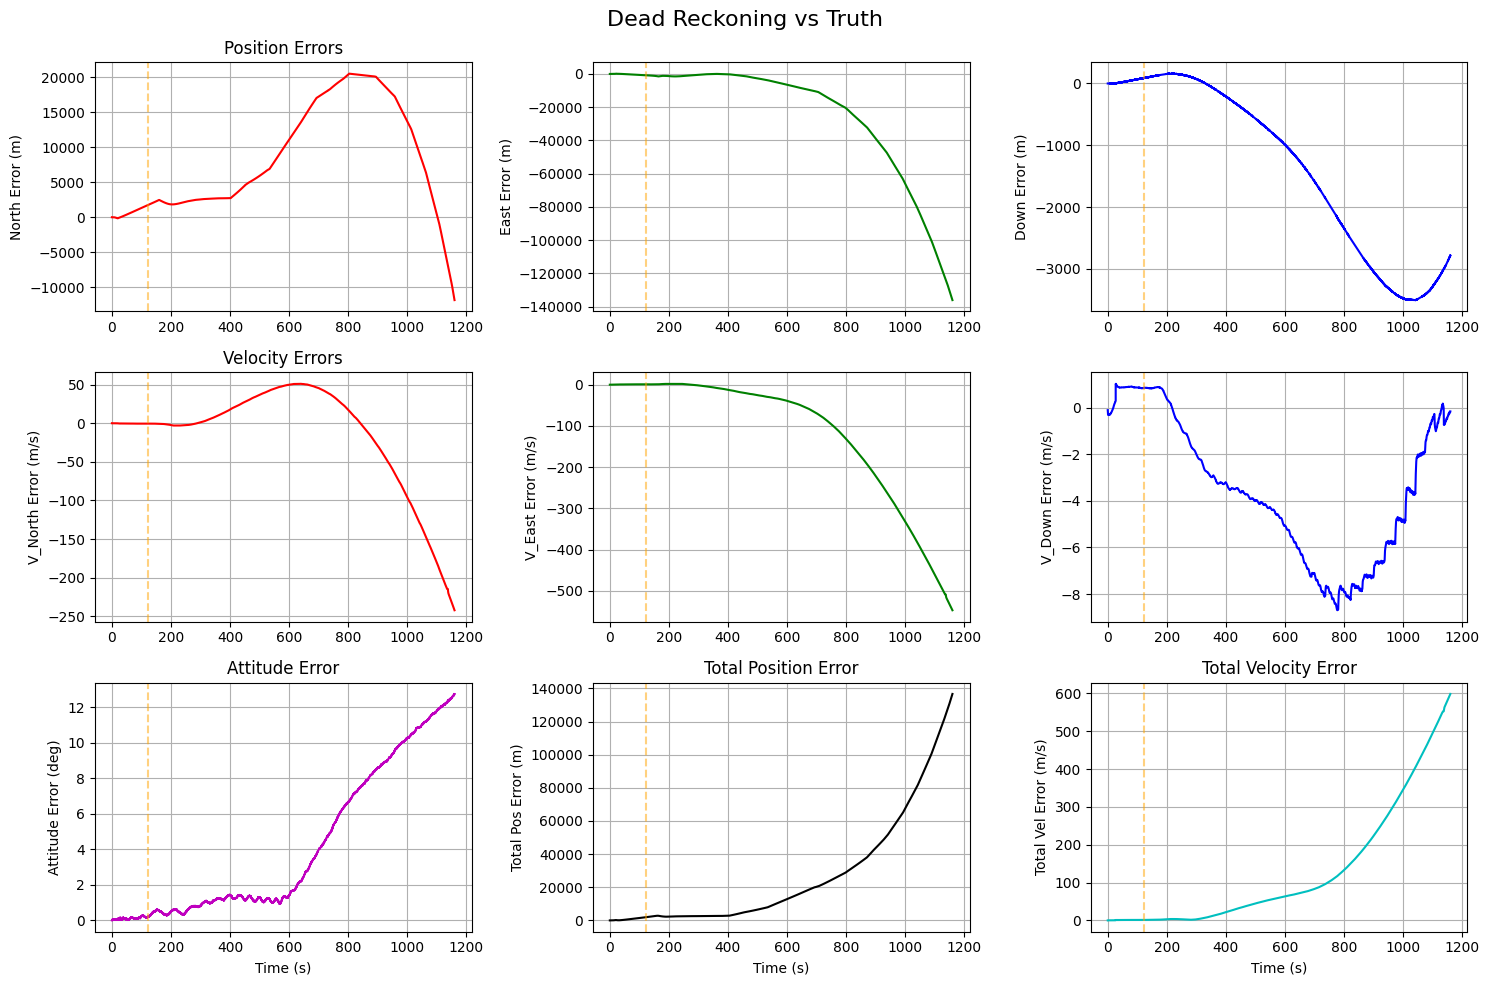


ERROR STATISTICS

Position error (m):
  Mean:  26802.35
  Std:   33710.40
  Max:   136688.80
  Final: 136688.80

Velocity error (m/s):
  Mean:    127.99
  Std:     160.44
  Max:     598.59
  Final:   598.59

Attitude error (deg):
  Mean:      4.14
  Std:       4.18
  Max:      12.76
  Final:    12.76

TESTING AROUND APOGEE

Running dead reckoning from t=117.4s to t=127.4s
  t= 117.4s: Pos_err=57186.00m, Vel_err= 80.47m/s, Att_err=53.93°
  t= 118.4s: Pos_err=57241.12m, Vel_err= 80.58m/s, Att_err=53.93°
  t= 119.4s: Pos_err=57296.18m, Vel_err= 80.69m/s, Att_err=53.92°
  t= 120.4s: Pos_err=57352.21m, Vel_err= 80.80m/s, Att_err=53.92°
  t= 121.4s: Pos_err=57408.06m, Vel_err= 80.90m/s, Att_err=53.94°
  t= 122.4s: Pos_err=57463.98m, Vel_err= 81.01m/s, Att_err=53.93°
  t= 123.4s: Pos_err=57520.29m, Vel_err= 81.13m/s, Att_err=53.94°
  t= 124.4s: Pos_err=57576.69m, Vel_err= 81.24m/s, Att_err=53.93°
  t= 125.4s: Pos_err=57633.91m, Vel_err= 81.34m/s, Att_err=53.92°
  t= 126.4s: Pos_err=57690.77m

In [22]:
"""
EKF Testing Framework 
"""

class EKFDeadReckoningTester:
    """
    Test dead reckoning performance against your MATLAB data
    """
    def __init__(self, matlab_data):
        self.data = matlab_data

        # EKF parameters matching MATLAB
        self.dt = DTYPE(0.01)  # 100 Hz
        self.we = DTYPE(0.0)  # Earth rotation (set to 0 in your MATLAB)
        self.a = DTYPE(6378137.0)
        self.b = DTYPE(6356752.31425)
        self.e2 = DTYPE(1.0 - (self.b/self.a)**2)
        
        # Process noise parameters (float32)
        nu_gv = DTYPE(12e-3)      # gyro velocity random walk [rad/s]
        nu_gu = DTYPE(3/3600)     # gyro bias instability [rad/s]
        nu_av = DTYPE(200e-6 * 9.81)  # accel velocity random walk [m/s^2]
        nu_au = DTYPE(40e-6 * 9.81)   # accel bias instability [m/s^2]

        # Build Q matrix (12x12) for full state
        self.Q = np.zeros((12, 12), dtype=DTYPE)
        self.Q[0:3, 0:3] = nu_gv * np.eye(3, dtype=DTYPE)      # Gyro velocity noise
        self.Q[3:6, 3:6] = nu_gu * np.eye(3, dtype=DTYPE)      # Gyro bias noise
        self.Q[6:9, 6:9] = nu_av * np.eye(3, dtype=DTYPE)      # Accel velocity noise
        self.Q[9:12, 9:12] = nu_au * np.eye(3, dtype=DTYPE)    # Accel bias noise
        # Scale by dt
        self.Q = dsp.arm_mat_scale_f32(self.Q, DTYPE(self.dt))[1]

        # Build Qq matrix (6x6) for reduced covariance
        self.Qq = np.zeros((6, 6), dtype=DTYPE)
        self.Qq[0:3, 0:3] = nu_gv * np.eye(3, dtype=DTYPE)     # Gyro velocity noise
        self.Qq[3:6, 3:6] = nu_gu * np.eye(3, dtype=DTYPE)     # Gyro bias noise
        # Scale by dt
        self.Qq = dsp.arm_mat_scale_f32(self.Qq, DTYPE(self.dt))[1]

        # State storage
        self.state_history = []
        self.error_history = {
            'pos_north': [],
            'pos_east': [],
            'pos_down': [],
            'vel_north': [],
            'vel_east': [],
            'vel_down': [],
            'attitude': []
        }

    def initialize_state(self):
        """Initialize state from MATLAB initial conditions"""
        state = np.zeros(22, dtype=DTYPE)

        # Initial quaternion
        state[0:4] = self.data.q[:, 0]

        # Initial position (LLA0)
        state[4:7] = self.data.LLA0

        # Initial velocity (should be zero)
        state[7:10] = self.data.velI[:, 0]

        return state.astype(DTYPE)
    
    def initialize_covariance(self):
        # match MATLAB sim
        P = np.eye(21, dtype=DTYPE) * DTYPE(1e-4)
        Pq = np.eye(6, dtype=DTYPE) * DTYPE(1e-4)
        return P, Pq
        

    def run_test(self, start_idx=0, end_idx=None):
        """Run dead reckoning through the trajectory"""
        if end_idx is None:
            end_idx = len(self.data.time)

        print(f"\nRunning dead reckoning from t={self.data.time[start_idx]:.1f}s to t={self.data.time[end_idx-1]:.1f}s")

        # Initialize
        self.state = self.initialize_state()
        self.P, self.Pq = self.initialize_covariance()
        self.state_history = []

        # Clear error history
        for key in self.error_history:
            self.error_history[key] = []

        # Progress reporting
        n_samples = end_idx - start_idx
        report_interval = max(1, n_samples // 10)

        for i in range(start_idx, end_idx):
            # Create IMU data
            imu = IMUData(
                gyro=self.data.gyro[:, i],
                accel=self.data.acc[:, i]
            )

            # Propagate
            self.state, self.P, self.Pq = propagate_state(
                self.state, self.P, self.Pq, self.Q, self.Qq, imu, self.we, self.dt, self.a, self.e2
            )

            # Store state
            self.state_history.append(self.state.copy())

            # Compute errors
            self.compute_errors(i)

            # Progress report
            if (i - start_idx) % report_interval == 0:
                t = self.data.time[i]
                pos_err = np.sqrt(
                    self.error_history['pos_north'][-1]**2 +
                    self.error_history['pos_east'][-1]**2 +
                    self.error_history['pos_down'][-1]**2
                )
                vel_err = np.sqrt(
                    self.error_history['vel_north'][-1]**2 +
                    self.error_history['vel_east'][-1]**2 +
                    self.error_history['vel_down'][-1]**2
                )
                att_err = self.error_history['attitude'][-1]

                print(f"  t={t:6.1f}s: Pos_err={pos_err:8.2f}m, "
                      f"Vel_err={vel_err:6.2f}m/s, Att_err={att_err:5.2f}°")

        self.state_history = np.array(self.state_history)
        print("\nDead reckoning complete!")
        
        # Print final state with quaternion, NED, and LLA
        print("\n" + "="*60)
        print("FINAL STATE")
        print("="*60)
        
        # Final quaternion
        q_final = self.state[0:4]
        print(f"Quaternion: [{q_final[0]:.6f}, {q_final[1]:.6f}, {q_final[2]:.6f}, {q_final[3]:.6f}]")
        
        # Final LLA position
        lla_final = self.state[4:7]
        print(f"LLA Position: Lat={lla_final[0]:.6f}°, Lon={lla_final[1]:.6f}°, Alt={lla_final[2]:.1f}m")
        
        # Convert LLA to NED for final position
        ned_final = self.lla2ned(lla_final, self.data.LLA0)
        print(f"NED Position: North={ned_final[0]:.1f}m, East={ned_final[1]:.1f}m, Down={ned_final[2]:.1f}m")
        
        # Final velocity (already in NED frame)
        vel_final = self.state[7:10]
        print(f"NED Velocity: North={vel_final[0]:.2f}m/s, East={vel_final[1]:.2f}m/s, Down={vel_final[2]:.2f}m/s")

    def compute_errors(self, idx):
        """Compute errors vs truth"""
        # Convert estimated LLA to NED
        lla_est = self.state[4:7]
        ned_est = self.lla2ned(lla_est, self.data.LLA0)

        # True NED
        ned_true = self.data.NED[:, idx]

        # Position errors
        self.error_history['pos_north'].append(ned_est[0] - ned_true[0])
        self.error_history['pos_east'].append(ned_est[1] - ned_true[1])
        self.error_history['pos_down'].append(ned_est[2] - ned_true[2])

        # Velocity errors
        vel_est = self.state[7:10]
        vel_true = self.data.velI[:, idx]
        self.error_history['vel_north'].append(vel_est[0] - vel_true[0])
        self.error_history['vel_east'].append(vel_est[1] - vel_true[1])
        self.error_history['vel_down'].append(vel_est[2] - vel_true[2])

        # Attitude error
        q_true = self.data.q[:, idx]
        q_est = self.state[0:4]

        # Error quaternion
        q_err = self.quat_mult(q_true, self.quat_conj(q_est))
        angle_error = 2 * np.arctan2(np.linalg.norm(q_err[1:4]), np.abs(q_err[0]))
        self.error_history['attitude'].append(np.degrees(angle_error))

    def lla2ecef(self, lla):
        """
        Convert LLA (Latitude, Longitude, Altitude) to ECEF (Earth-Centered Earth-Fixed)
        
        Args:
            lla: [latitude (deg), longitude (deg), altitude (m)]
        
        Returns:
            ecef: [x, y, z] in meters
        
        Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equations A.238-A.239
        Verified with Google Maps
        """
        lla = np.array(lla, dtype=DTYPE).flatten()
        
        # WGS84 parameters
        a = DTYPE(6378137.0)        # semi-major axis [m]
        b = DTYPE(6356752.3124)     # semi-minor axis [m]  
        e = DTYPE(0.08181919)       # eccentricity
        
        phi = lla[0]      # latitude in degrees
        lambda_ = lla[1]  # longitude in degrees
        h = lla[2]        # altitude in meters
        
        # Convert to radians for trig functions
        phi_rad = phi * np.pi / 180.0
        lambda_rad = lambda_ * np.pi / 180.0
        
        # Compute N (prime vertical radius of curvature) - equation A.238
        sin_phi = np.sin(phi_rad)
        N = a / np.sqrt(1.0 - (e * sin_phi)**2)
        
        # Compute ECEF coordinates - equation A.239
        cos_phi = np.cos(phi_rad)
        cos_lambda = np.cos(lambda_rad)
        sin_lambda = np.sin(lambda_rad)
        
        x = (N + h) * cos_phi * cos_lambda
        y = (N + h) * cos_phi * sin_lambda
        z = (N * (1.0 - e**2) + h) * sin_phi
        
        ecef = np.array([x, y, z], dtype=DTYPE)
        
        return ecef


    def ecef2ned(self, ecef, lla0):
        """
        Convert ECEF to NED (North-East-Down) frame relative to reference point
        
        Args:
            ecef: [x, y, z] in ECEF frame [m]
            lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
        
        Returns:
            ned: [north, east, down] in meters relative to lla0
        
        Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equation A.242
        """
        ecef = np.array(ecef, dtype=DTYPE).flatten()
        lla0 = np.array(lla0, dtype=DTYPE).flatten()
        
        # Get ECEF of NED origin
        ecef0 = self.lla2ecef(lla0)
        
        # Reference point angles
        phi = lla0[0]      # latitude in degrees
        lambda_ = lla0[1]  # longitude in degrees
        # Convert to radians
        phi_rad = phi * np.pi / 180.0
        lambda_rad = lambda_ * np.pi / 180.0
        # Precompute trig functions
        s1 = np.sin(phi_rad)
        c1 = np.cos(phi_rad)
        s2 = np.sin(lambda_rad)
        c2 = np.cos(lambda_rad)
        # Build ECEF to NED rotation matrix (DCM) - equation A.242
        # This transforms from ECEF frame to NED frame centered at lla0
        Ae2n = np.array([
            [-s1*c2, -s1*s2,  c1],
            [-s2,     c2,     0.0],
            [-c1*c2, -c1*s2, -s1]
        ], dtype=DTYPE)
        # Compute relative ECEF position using CMSIS-DSP
        delta_ecef = dsp.arm_sub_f32(ecef, ecef0)
        # Transform to NED using matrix-vector multiply
        # Using CMSIS-DSP dot products for each row
        ned = dsp.arm_mat_vec_mult_f32(Ae2n, delta_ecef)
        return ned


    def lla2ned(self, lla, lla0):
        """
        Convert LLA to NED frame relative to reference point
        
        Args:
            lla: [latitude (deg), longitude (deg), altitude (m)]
            lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
        
        Returns:
            ned: [north, east, down] in meters relative to lla0
        
        This is the main function used in the EKF for position conversions.
        Combines lla2ecef and ecef2ned transformations.
        """
        # Convert LLA to ECEF
        ecef = self.lla2ecef(lla)
        # Convert ECEF to NED relative to reference
        ned = self.ecef2ned(ecef, lla0)
        return ned


    def quat_mult(self, q1, q2):
        """Quaternion multiplication"""
        return dsp.arm_quaternion_product_single_f32(q1,q2)

    def quat_conj(self, q):
        """Quaternion conjugate"""
        return dsp.arm_quaternion_conjugate_f32(q)

    def plot_results(self):
        """Generate comparison plots"""
        time = self.data.time[:len(self.state_history)]

        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
        fig.suptitle('Dead Reckoning vs Truth', fontsize=16)

        # Position errors
        axes[0,0].plot(time, self.error_history['pos_north'], 'r-')
        axes[0,0].set_ylabel('North Error (m)')
        axes[0,0].grid(True)
        axes[0,0].set_title('Position Errors')

        axes[0,1].plot(time, self.error_history['pos_east'], 'g-')
        axes[0,1].set_ylabel('East Error (m)')
        axes[0,1].grid(True)

        axes[0,2].plot(time, self.error_history['pos_down'], 'b-')
        axes[0,2].set_ylabel('Down Error (m)')
        axes[0,2].grid(True)

        # Velocity errors
        axes[1,0].plot(time, self.error_history['vel_north'], 'r-')
        axes[1,0].set_ylabel('V_North Error (m/s)')
        axes[1,0].grid(True)
        axes[1,0].set_title('Velocity Errors')

        axes[1,1].plot(time, self.error_history['vel_east'], 'g-')
        axes[1,1].set_ylabel('V_East Error (m/s)')
        axes[1,1].grid(True)

        axes[1,2].plot(time, self.error_history['vel_down'], 'b-')
        axes[1,2].set_ylabel('V_Down Error (m/s)')
        axes[1,2].grid(True)

        # Attitude and total errors
        axes[2,0].plot(time, self.error_history['attitude'], 'm-')
        axes[2,0].set_ylabel('Attitude Error (deg)')
        axes[2,0].set_xlabel('Time (s)')
        axes[2,0].grid(True)
        axes[2,0].set_title('Attitude Error')

        # Total position error
        pos_err_total = np.sqrt(
            np.array(self.error_history['pos_north'])**2 +
            np.array(self.error_history['pos_east'])**2 +
            np.array(self.error_history['pos_down'])**2
        )
        axes[2,1].plot(time, pos_err_total, 'k-')
        axes[2,1].set_ylabel('Total Pos Error (m)')
        axes[2,1].set_xlabel('Time (s)')
        axes[2,1].grid(True)
        axes[2,1].set_title('Total Position Error')

        # Total velocity error
        vel_err_total = np.sqrt(
            np.array(self.error_history['vel_north'])**2 +
            np.array(self.error_history['vel_east'])**2 +
            np.array(self.error_history['vel_down'])**2
        )
        axes[2,2].plot(time, vel_err_total, 'c-')
        axes[2,2].set_ylabel('Total Vel Error (m/s)')
        axes[2,2].set_xlabel('Time (s)')
        axes[2,2].grid(True)
        axes[2,2].set_title('Total Velocity Error')

        # Mark apogee
        apogee_time = self.data.time[self.data.apogee_idx]
        for ax in axes.flat:
            ax.axvline(apogee_time, color='orange', linestyle='--', alpha=0.5, label='Apogee')

        plt.tight_layout()
        plt.show()

        # Print statistics
        self.print_statistics()

    def print_statistics(self):
        """Print error statistics"""
        print("\n" + "="*60)
        print("ERROR STATISTICS")
        print("="*60)

        # Compute total errors
        pos_err_total = np.sqrt(
            np.array(self.error_history['pos_north'])**2 +
            np.array(self.error_history['pos_east'])**2 +
            np.array(self.error_history['pos_down'])**2
        )

        vel_err_total = np.sqrt(
            np.array(self.error_history['vel_north'])**2 +
            np.array(self.error_history['vel_east'])**2 +
            np.array(self.error_history['vel_down'])**2
        )

        att_err = np.array(self.error_history['attitude'])

        print(f"\nPosition error (m):")
        print(f"  Mean:  {np.mean(pos_err_total):8.2f}")
        print(f"  Std:   {np.std(pos_err_total):8.2f}")
        print(f"  Max:   {np.max(pos_err_total):8.2f}")
        print(f"  Final: {pos_err_total[-1]:8.2f}")

        print(f"\nVelocity error (m/s):")
        print(f"  Mean:  {np.mean(vel_err_total):8.2f}")
        print(f"  Std:   {np.std(vel_err_total):8.2f}")
        print(f"  Max:   {np.max(vel_err_total):8.2f}")
        print(f"  Final: {vel_err_total[-1]:8.2f}")

        print(f"\nAttitude error (deg):")
        print(f"  Mean:  {np.mean(att_err):8.2f}")
        print(f"  Std:   {np.std(att_err):8.2f}")
        print(f"  Max:   {np.max(att_err):8.2f}")
        print(f"  Final: {att_err[-1]:8.2f}")


# Test execution
def test_dead_reckoning(mat_file_path):
    """Main test function"""
    print("="*60)
    print("DEAD RECKONING VALIDATION")
    print("Python CMSIS-DSP vs MATLAB Truth")
    print("="*60)

    # Load data
    matlab_data = MATLABDataLoader(mat_file_path)

    # Create tester
    tester = EKFDeadReckoningTester(matlab_data)

    # Test full trajectory
    tester.run_test()

    # Generate plots
    tester.plot_results()

    # Test around apogee specifically
    print("\n" + "="*60)
    print("TESTING AROUND APOGEE")
    print("="*60)

    apogee_idx = matlab_data.apogee_idx
    start = max(0, apogee_idx - 500)  # 5 seconds before
    end = min(len(matlab_data.time), apogee_idx + 500)  # 5 seconds after

    tester_apogee = EKFDeadReckoningTester(matlab_data)
    tester_apogee.run_test(start, end)

    return tester, matlab_data


if __name__ == "__main__":
    # Run the test
    tester, data = test_dead_reckoning(TEST_DATA_FILE_PATH)

In [23]:
class EKF:
    """
    Test dead reckoning performance against your MATLAB data
    """
    def __init__(self, IMU_parameters, sensors_parameters, baro_h_func, initial_conditions):

        # constants matching MATLAB
        self.we = DTYPE(0.0)  # Earth rotation (set to 0 in your MATLAB)
        self.a = DTYPE(6378137.0)
        self.b = DTYPE(6356752.31425)
        self.e2 = DTYPE(1.0 - (self.b/self.a)**2)

        # IMU and sensor parameters
        self.dt = DTYPE(0.01)  # 100 Hz
        self.gyro_noise_std = DTYPE(0.01)  # rad/sqrt(s)
        self.accel_noise_std = DTYPE(0.1)  # m/s^2/sqrt(s)
        self.gps_horiz_noise_std = DTYPE(3.0)  
        self.gps_vert_noise_std = DTYPE(5.0)
        self.mag_noise_std = DTYPE(0.5)  # microtesla
        self.baro_noise_std = DTYPE(1.0)  # meters

        # State storage
        self.state_history = []
        self.error_history = {
            'pos_north': [],
            'pos_east': [],
            'pos_down': [],
            'vel_north': [],
            'vel_east': [],
            'vel_down': [],
            'attitude': []
        }

    def initialize_state(self):
        """Initialize state from MATLAB initial conditions"""
        state = np.zeros(22, dtype=DTYPE)

        # Initial quaternion
        state[0:4] = self.data.q[:, 0]

        # Initial position (LLA0)
        state[4:7] = self.data.LLA0

        # Initial velocity (should be zero)
        state[7:10] = self.data.velI[:, 0]

        return state.astype(DTYPE)
    
    def initialize_covariance(self):
        

    def run_EKF(self, start_idx=0, end_idx=None):
        """Run dead reckoning through the trajectory"""
        if end_idx is None:
            end_idx = len(self.data.time)

        print(f"\nRunning dead reckoning from t={self.data.time[start_idx]:.1f}s to t={self.data.time[end_idx-1]:.1f}s")

        # Initialize
        self.state = self.initialize_state()
        self.state_history = []

        # Clear error history
        for key in self.error_history:
            self.error_history[key] = []

        # Progress reporting
        n_samples = end_idx - start_idx
        report_interval = max(1, n_samples // 10)

        for i in range(start_idx, end_idx):
            # Create IMU data
            imu = IMUData(
                gyro=self.data.gyro[:, i],
                accel=self.data.acc[:, i]
            )

            # Propagate
            self.state = propagate_state(
                self.state, imu, self.we, self.dt, self.a, self.e2
            )

            # Store state
            self.state_history.append(self.state.copy())

            # Compute errors
            self.compute_errors(i)

            # Progress report
            if (i - start_idx) % report_interval == 0:
                t = self.data.time[i]
                pos_err = np.sqrt(
                    self.error_history['pos_north'][-1]**2 +
                    self.error_history['pos_east'][-1]**2 +
                    self.error_history['pos_down'][-1]**2
                )
                vel_err = np.sqrt(
                    self.error_history['vel_north'][-1]**2 +
                    self.error_history['vel_east'][-1]**2 +
                    self.error_history['vel_down'][-1]**2
                )
                att_err = self.error_history['attitude'][-1]

                print(f"  t={t:6.1f}s: Pos_err={pos_err:8.2f}m, "
                      f"Vel_err={vel_err:6.2f}m/s, Att_err={att_err:5.2f}°")

        self.state_history = np.array(self.state_history)
        print("\nDead reckoning complete!")
        
        # Print final state with quaternion, NED, and LLA
        print("\n" + "="*60)
        print("FINAL STATE")
        print("="*60)
        
        # Final quaternion
        q_final = self.state[0:4]
        print(f"Quaternion: [{q_final[0]:.6f}, {q_final[1]:.6f}, {q_final[2]:.6f}, {q_final[3]:.6f}]")
        
        # Final LLA position
        lla_final = self.state[4:7]
        print(f"LLA Position: Lat={lla_final[0]:.6f}°, Lon={lla_final[1]:.6f}°, Alt={lla_final[2]:.1f}m")
        
        # Convert LLA to NED for final position
        ned_final = self.lla2ned(lla_final, self.data.LLA0)
        print(f"NED Position: North={ned_final[0]:.1f}m, East={ned_final[1]:.1f}m, Down={ned_final[2]:.1f}m")
        
        # Final velocity (already in NED frame)
        vel_final = self.state[7:10]
        print(f"NED Velocity: North={vel_final[0]:.2f}m/s, East={vel_final[1]:.2f}m/s, Down={vel_final[2]:.2f}m/s")


IndentationError: expected an indented block after function definition on line 49 (3912105025.py, line 52)